In [138]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import numpy as np
from numpy import pi 
from numpy.random import rand
import matplotlib.pyplot as plt
#import scipy.fftpack as fft
import numpy.fft as fft
from math import pi
import time

In [318]:
class SimSp():
    
     
    def __init__(self,BW=10000, SD = 0.1):
        #super(SimSp, self).__init__()
        self.name = 'myMRS'        # Name you want to give to the simulated spectrum.
        self.BW = BW         # Bandwidth of the simulated spectrum [Hz]. ( BW=1/dt with dt is the sampling interval [s] ) 
        self.SD = SD     # Sampling duration of the signal [s]. ( SD=dt*(npoints-1[?])  with np is the number of samples )
        self.time0 = 0   # Time between the excitation and the start of the sampling. (For 0 order correction)
        self.B0 = 3          # Stregth of the main B0 field [T]
        
        self.dt= 0.5/self.BW
        self.npoints=int(self.SD*self.BW+1)
        
        
        self.t= np.linspace(self.time0,self.SD,self.npoints)
        self.sig=np.zeros(self.t.shape)
        self.freq=np.zeros(self.t.shape)
        self.spec=np.zeros(self.t.shape)

        self.theta_autoshit=[]
        self.noiseval=[]
        
        self.apofuction=[]
        self.apostregth=[]
        
        self.npeaks=0
        self.mets=[]
        
        self.nuc = 'H'  # Nucleus giving the signal
        if self.nuc is 'H':
            self.gamma = 42.57747892  #   Nucleus	1H --> gyro= 267.5221900 [MRad/s/T] or  42.57747892 [MHz/T]
            self.carrier = self.gamma*self.B0  # Carrier frequency in MHz
            
    def addpeak(self,ppm=1, magnitude=1, phase= 0 ,T2=100):
        self.ppm = ppm          # Chemical shift relative to TMS in ppm
        self.magnitude = magnitude         # Magniude of the signal 
        self.phase= phase     # Phase of the signal 
        self.T2=T2  # T2 of the resonance (ms)
        
        self.w = self.ppm*self.carrier*2*np.pi #demodulated angular frequency (Hz)
        self.npeaks+= 1  #peak counter
        #self.mets = self.mets.append("".join(map(str, ['Peak',self.npeaks])))    # Name of the molecule giving the nmr peak, e.g. Lac, Cho, NAA.
        self.sig=self.sig+self.magnitude*np.exp(1j*(self.w*self.t+self.phase))*np.exp(-self.t*1000/self.T2)
       
    
        #print(self.npoints, self.dt)
        self.spec=fft.fftshift(fft.fft(self.sig))*2/self.npoints
        self.freq=fft.fftshift(fft.fftfreq(self.npoints))*self.BW
        #self.freq=np.linspace(-1,1,int(self.npoints))*self.BW/2;
    
        
    def autoshift(self, method='fast'):
        self.method = method
        if self.method==360:
            print(self.method)
            mysum=np.zeros(360)
            for ii in range(360):
                #theta2=theta-np.pi/4+np.pi/4/8*(ii)
                theta=2*pi/359*ii
                self.spec_shitted=self.spec*np.exp(1j*theta)
                spreal=np.real(self.spec_shitted)
                mysum[ii]=np.sum(spreal)          
        
            pie360th=np.argmax(mysum)
            autotheta=2*pi/359*pie360th
        
            self.sig=self.sig*np.exp(1j*autotheta)
            self.spec=fft.fftshift(fft.fft(self.sig))*2/self.npoints
                
        else:       
            print(self.method)
            mysum=np.zeros(20)
            for ii in range(20):
                theta=2*pi/20*ii
                #self.sig_shitted=self.sig*np.exp(1j*theta)
                #self.spec_shitted=fft.fftshift(fft.fft(self.sig_shitted))
                self.spec_shitted=self.spec*np.exp(1j*theta)
                spreal=np.real(self.spec_shitted)
                mysum[ii]=np.sum(spreal)  

            pie20th=np.argmax(mysum)
            theta=2*pi/20*pie20th
            
            mysum=np.zeros(21)
            for ii in range(21):
                #theta2=theta-np.pi/4+np.pi/4/8*(ii)
                theta2=theta-pi/20+(pi/200*ii)
                #self.sig_shitted=self.sig*np.exp(1j*theta2)
                #self.spec_shitted=fft.fftshift(fft.fft(self.sig_shitted))
                self.spec_shitted=self.spec*np.exp(1j*theta2)
                spreal=np.real(self.spec_shitted)
                mysum[ii]=np.sum(spreal)          

            pie400th=np.argmax(mysum)
            autotheta=theta-pi/20+(pi/200*pie400th)

            self.sig=self.sig*np.exp(1j*autotheta)
            self.spec=fft.fftshift(fft.fft(self.sig))*2/self.npoints
            
        self.theta_autoshit=2*pi-autotheta
        

    def show(self,show_what=0):
        show_what=show_what
        
        if show_what=='both':
            plt.subplot(2,1,1); plt.plot(self.t,np.real(self.sig)); plt.plot(self.t,np.imag(self.sig)); 
            plt.ylabel('Signal'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.real(self.spec)); plt.plot(self.freq/self.carrier,np.imag(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Spectrum');  plt.xlabel('Frequency [ppm]')
            plt.legend(['Real','Imaginary'])
        
        elif show_what=='amplitude':
            plt.subplot(2,1,1); plt.plot(self.t,np.abs(self.sig))
            plt.ylabel('Signal magnitude'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.abs(self.spec)); plt.plot(self.freq/self.carrier,np.angle(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Amplitude spectrum');  plt.xlabel('Frequency [ppm]')
            plt.legend(['Amplitude','Phase'])
        else:    
            plt.subplot(2,1,1); plt.plot(self.t,np.real(self.sig)); #plt.plot(self.t,np.imag(self.sig)); 
            plt.ylabel('Reals signal'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.real(self.spec)); #plt.plot(self.freq/self.carrier,np.imag(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Real spectrum');  plt.xlabel('Frequency [ppm]')
            #plt.legend(['Real','Imaginary'])
            
    
        
    def addnoise(self,noiseval=1):
        self.noiseval=noiseval
        noise=rand(*self.sig.shape)*self.noiseval-noiseval/2
        self.sig=self.sig+noise
        self.spec=fft.fftshift(fft.fft(self.sig))*2/self.npoints
        
        
    def apodise(self,apofuction='half_exp',apostregth=np.e):
        self.apofuction=apofuction
        self.apostregth=apostregth
        if self.apofuction=='half_exp':
            apod1=np.ones(int(self.npoints/2))
            apod2=np.exp(-np.linspace(0,self.apostregth,self.npoints-int(self.npoints/2)))
            apod=np.append(apod1,apod2)
        elif self.apofuction=='exp':
            apod=np.exp(-np.linspace(0,self.apostregth,self.npoints))
            
        self.sig=self.sig*apod
        self.spec=fft.fftshift(fft.fft(self.sig))*2/self.npoints                 

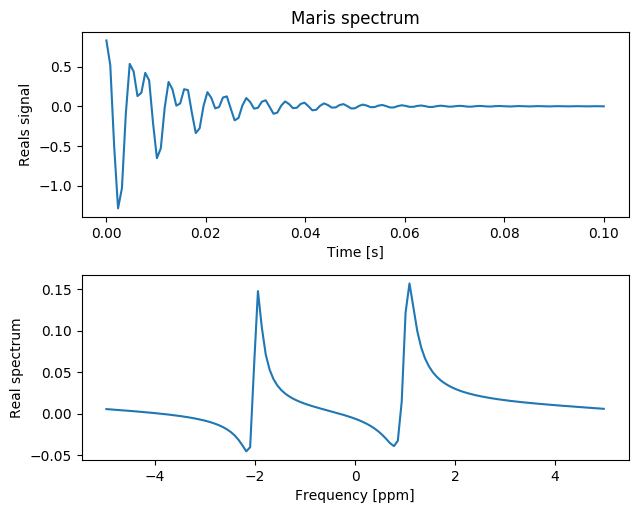

In [319]:
maris_nmr=SimSp(BW=1280,SD=0.1)      
maris_nmr.name='Maris spectrum'
  
maris_nmr.addpeak(ppm=1,magnitude=1, T2=10,phase=pi/3)  
maris_nmr.addpeak(ppm=-2,magnitude=0.66, T2=15,phase=pi/3)  
#maris_nmr.addpeak(ppm=-3,magnitude=30, phase=pi/2)  
#maris_nmr.addpeak(ppm=4,magnitude=10, phase=pi/2)  
maris_nmr.addnoise(noiseval=0)

maris_nmr.show()

fast
Shift found 1.052433538952581 radians


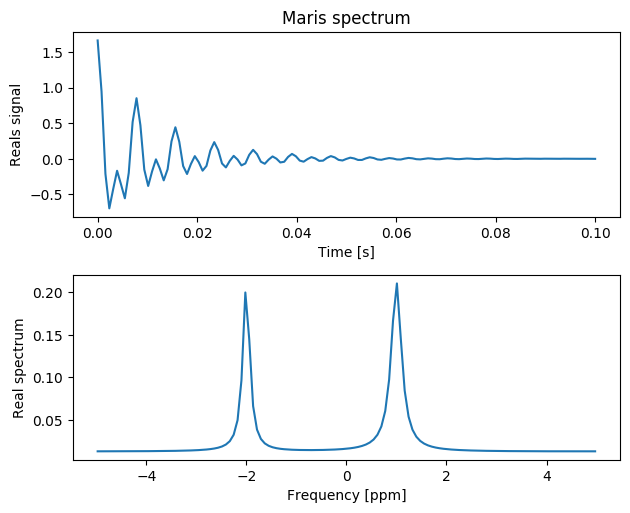

In [320]:
maris_nmr.autoshift()
print('Shift found ' + str(maris_nmr.theta_autoshit) +' radians')
maris_nmr.show()

/Users/papo/.virtualenvs/pat37/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/papo/.virtualenvs/pat37/lib/python3.7/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


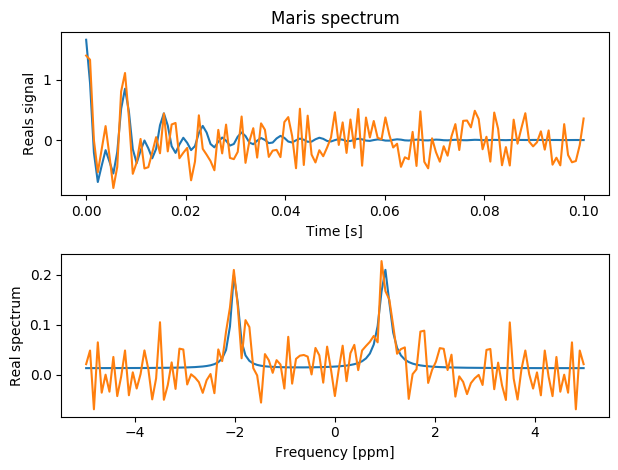

In [321]:
maris_nmr.show('')
maris_nmr.addnoise(1)
maris_nmr.show('')

#plt.style.use('fivethirtyeight')
#plt.style.use('default')



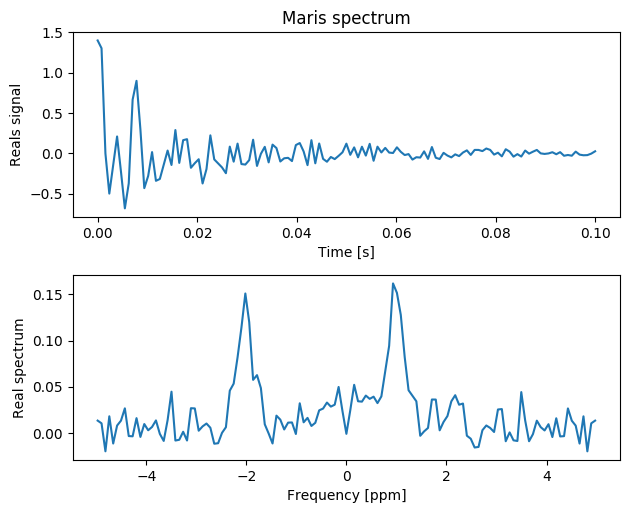

In [322]:
maris_nmr.apodise('exp')
maris_nmr.show('')

In [291]:

a=np.array([1,45,4,5,3,5,6,22])
a[int((len(a)-1)/2)]=23
a[-1]
print(a)
b=a[2:4]+4
c=np.append(a,b)
d=np.exp(-np.linspace(0,np.e,10))
print(d)

[ 1 45  4 23  3  5  6 22]
[1.         0.73931491 0.54658654 0.40409958 0.29875685 0.22087539
 0.16329647 0.12072752 0.08925565 0.06598804]


In [272]:
np.exp(-np.e)

0.06598803584531254

In [271]:
np.e

2.718281828459045